# Understanding Discourse Data

In [1]:
# load all necessary libraries
import pandas as pd
import itertools
import numpy as np
import seaborn 
import matplotlib.pyplot as plt
import nltk
import re
import string
import lightgbm as lgb
import xgboost as xgb

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from itertools import product
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline 
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
    

In [5]:
# load data for Text Classification
discoursesingle = pd.read_csv(r"C:\Masters\Masters in Data Science\Research\EDA\Data\Revised Data\FinalData\Singletextclassification50K.txt", sep = "\t", names=["humanvalue", "text"])
discoursesingle = discoursesingle.iloc[1:]
discoursesingle['label'] =discoursesingle['humanvalue']
discoursesingle.loc[discoursesingle['humanvalue'] == "Other",'label'] = 0 #0 for Truth
discoursesingle.loc[discoursesingle['humanvalue'] == "Right_Conduct",'label'] = 1 #1 for Right Conduct
discoursesingle.loc[discoursesingle['humanvalue'] == "Love",'label'] = 2 # 3 for love
discoursesingle.groupby('text').describe() # decribe data

humanvalue         \
                                                        count unique   
text                                                                   
 Each one of you is an embodiment of love, but ...         70      1   
 I appeal to all of you, to strive in this dire...         70      1   
 I have not come to speak on behalf of any part...         70      1   
 If there is righteousness in the heart,  there...         70      1   
 In the battle against the Rakshasas in Lanka, ...         70      1   
 In the midst of the world replete with fear, d...         70      1   
 It is said, Jantunām narajanma durlabham (Birt...         70      1   
 Once peace of mind is achieved, all other cond...         70      1   
 So do not hate anybody. In this world people a...         70      1   
 So long as a person follows the head alone, ne...         70      1   
 The dualities of righteousness and unrighteous...         70      1   
 The various contexts in which the word love is...         70      1   
 Therefore, always love that Parātatwa. Do not ...         70      1   
 They are not making any effort to realise the ...         70      1   
 This kind of prema and truth are present in ev...         70      1   
 What is Dharma? Dharma is to follow the teachi...         70      1   
 When this love is manifested by a person, he o...         70      1   
 When you truly experience Divine Love, you wil...         70      1   
 Where is Shanthi (Peace)? Is it outside? No. i...         70      1   
 Women in particular must be on their guard, be...         70      1   
 Your love becomes worldly in nature when you h...         70      1   
A child becomes a youth and a youth becomes old...         70      1   
A disbeliever will say there is no God. Another...         70      1   
A hundred eyes will be watching every word and ...        140      1   
A key component of Sathya Sai Education is the ...         70      1   
A life without love is meaningless. The more yo...         70      1   
A man who has no love in him is as barren as a ...         70      1   
A person might be an expert in any field of kno...         70      1   
A person who seeks an enlightened existence mus...         70      1   
Acquire love through love. Only through love ca...         70      1   
...                                                       ...    ...   
You can judge for yourself how dharma can be un...         70      1   
You can remain in the world for any number of y...         70      1   
You can teach love to students only through lov...         70      1   
You do not have to practise all that you read. ...         70      1   
You have come from God, you are a spark of His ...         70      1   
You have come from different countries and you ...         70      1   
You have it in your power to make your days on ...         70      1   
You have to make your mother happy. Only then w...         70      1   
You may acquire various types of knowledge and ...         70      1   
You may ask, how is it that what we see during ...         70      1   
You may be getting some doubts as to whether we...         70      1   
You may chant any Name, contemplate on any form...         70      1   
You may get another doubt. You may ask a questi...         70      1   
You might have read in the Mahabharata that Bhi...         70      1   
You must welcome tests because it gives you con...         70      1   
You need not surrender anything at all. Love al...         70      1   
You should also be careful with regard to your ...         70      1   
You should be careful not only with regard to h...        140      1   
You should get rid of weakness by concentrating...         70      1   
You should not misunderstand and misinterpret w...         70      1   
You should understand that there is not one sin...         70      1   
You young students who have come here and who a...         70      1   
Your love should no

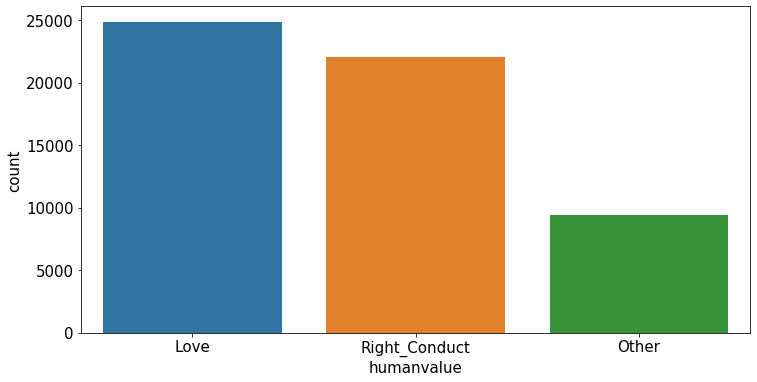

In [6]:
# Clean the data
discoursesingle.groupby('text').describe() # decribe data

# Observe Size
category_count = pd.DataFrame()
category_count['count'] = discoursesingle['humanvalue'].value_counts()
fig, ax = plt.subplots(figsize = (12, 6))
seaborn.barplot(x = category_count.index, y = category_count['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('humanvalue',fontsize = 15)
ax.tick_params(labelsize=15)

,humanvalue,text,label
1,Truth,life is love enjoy it,Truth
2,Love,do not use poisonous words against anyone for...,2
3,Nonviolence,the end of education is character,Nonviolence
4,Truth,as worldly thoughts diminish thoughts of god ...,Truth
5,Peace,there is only one caste the caste of humanity...,Peace


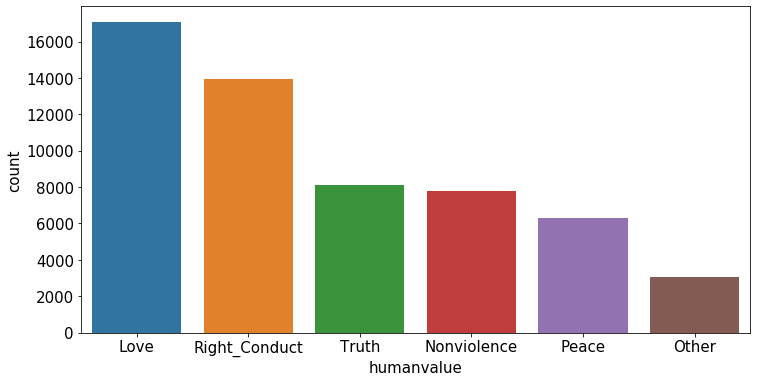

In [3]:
# Clean the data
discoursesingle.groupby('text').describe() # decribe data

# Observe Size
category_count = pd.DataFrame()
category_count['count'] = discoursesingle['humanvalue'].value_counts()
fig, ax = plt.subplots(figsize = (12, 6))
seaborn.barplot(x = category_count.index, y = category_count['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('humanvalue',fontsize = 15)
ax.tick_params(labelsize=15)


def clean_data(sentence):
    ## removing web links
    s = [ re.sub(r'http\S+', '', sentence.lower())]
    ## removing words like gooood and poooor to good and poor
    s = [''.join(''.join(s)[:2] for _, s in itertools.groupby(s[0]))]
    ## removing appostophes
    s = [remove_appostophes(s[0])]
    ## removing punctuations from the code 
    s = [remove_punctuations(s[0])]
    return s[0]

def remove_punctuations(my_str):
    punctuations = '''!()-[]{};:'"\,./?@#$%^&@*_~'''
    no_punct = ""
    for char in my_str:
       if char not in punctuations:
           no_punct = no_punct + char
    return no_punct

def remove_appostophes(sentence):
    APPOSTOPHES = {"s" : "is", "re" : "are", "t": "not", "ll":"will","d":"had","ve":"have","m": "am"}
    words = nltk.tokenize.word_tokenize(sentence)
    final_words=[]
    for word in words:
        broken_words=word.split("'")
        for single_words in broken_words:
            final_words.append(single_words)
    reformed = [APPOSTOPHES[word] if word in APPOSTOPHES else word for word in final_words]
    reformed = " ".join(reformed)
    return reformed

## Sample Sentence to be cleaned
sentence="('Ahimso paramo dharmaha!' Nonvoilence is the best practice,')"
 
## Using clean_data function
clean_data(sentence)

# The clean data is working as expected, now let us clean corpus data

# Remove blank rows if any.
discoursesingle['text'].dropna(inplace=True)

# Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
discoursesingle['text'] = [entry.lower() for entry in discoursesingle['text']]

for index in range(0,len(discoursesingle["text"])):
    discoursesingle.loc[index,"text"] = clean_data(discoursesingle["text"].iloc[index])
    
discoursesingle.head() # Data looks cleaned


In [7]:
# Create seperate dataframes for labels
discourseLove = discoursesingle[discoursesingle['humanvalue'] == 'Love']
discourseRC = discoursesingle[discoursesingle['humanvalue'] == 'Right_Conduct']
discourseOthr = discoursesingle[discoursesingle['humanvalue'] == 'Other']

discourseLove = discourseLove.drop(['humanvalue', 'label'], axis=1)
discourseRC = discourseRC.drop(['humanvalue', 'label'], axis=1)
discourseOthr = discourseOthr.drop(['humanvalue', 'label'], axis=1)


### Preprocessing

In [8]:
## initialise the inbuilt Stemmer and the Lemmatizer
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [9]:
## Converting the read dataset in to a list of tuples, each tuple(row) contianing the message and it's label#data_set = []

data_set = []

for index,row in discoursesingle.iterrows():
    data_set.append((row['text'], row['label'],row['humanvalue']))

#change to lower case, Tokenize and removes stopwords
def preprocess(document, stem):
    
    # change sentence to lower case
    document = document.lower()
    
    # tokenize into words
    words = word_tokenize(document)
    
    # remove stop words and words less than 3 characters
    words = [word for word in words if word not in stopwords.words("english")]
    
    # replace sanskrit words represented in English to English words
    #replace Prema to Love ; Dharma to righteousness ; sathya to truth ; Shanthi / Santhi / Shanti to peace; Ahimsa to Nonviolence  
    words = [word.replace("prema","love") for word in words]
    words = [word.replace("dharma","righteousness") for word in words]
    words = [word.replace("dharmo","righteousness") for word in words]
    words = [word.replace("sathya","truth") for word in words]
    words = [word.replace("shanthi","peace") for word in words]
    words = [word.replace("santhi","peace") for word in words]
    words = [word.replace("shanti","peace") for word in words]
    words = [word.replace("ahimsa","nonviolence") for word in words]
    
    # join words to make sentence
    
    if stem:
        words = [stemmer.stem(word) for word in words]
    else:
        words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    
    document = " ".join(words)

    return document

## - Performing the preprocessing steps on all messages with length >= 3
wordtokenized = []
for (text, label,humanvalue) in data_set:
    words_filtered = [e.lower() for e in preprocess(text,stem=False).split() if len(e) >= 3]
    wordtokenized.append((words_filtered, label,humanvalue))   

print(wordtokenized[:5])

[(['life', 'song', 'sing', 'life', 'game', 'play', 'life', 'challenge', 'meet', 'life', 'dream', 'realize', 'life', 'sacrifice', 'offer'], 1, 'Right_Conduct'), (['life', 'love', 'enjoy'], 2, 'Love'), (['use', 'poisonous', 'word', 'anyone', 'word', 'wind', 'fatally', 'even', 'arrows'], 2, 'Love'), (['end', 'education', 'character'], 1, 'Right_Conduct'), (['worldly', 'thoughts', 'diminish', 'thoughts', 'god', 'increase', 'normally', 'mind', 'time', 'desire', 'worldly', 'things', 'desire', 'cut', 'one', 'one', 'peace', 'become', 'stronger'], 0, 'Other')]


Word Cloud based on Discourse - Love


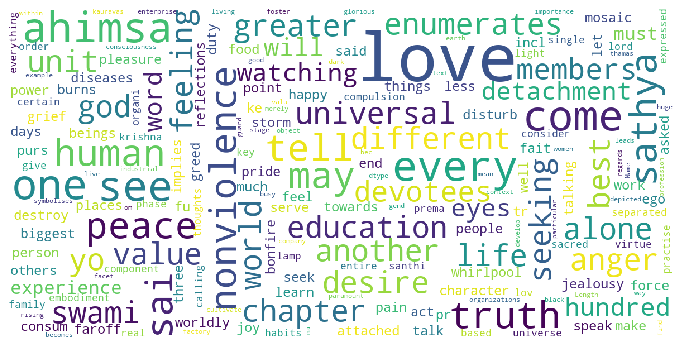

Word Cloud based on Discourse - Right Conduct


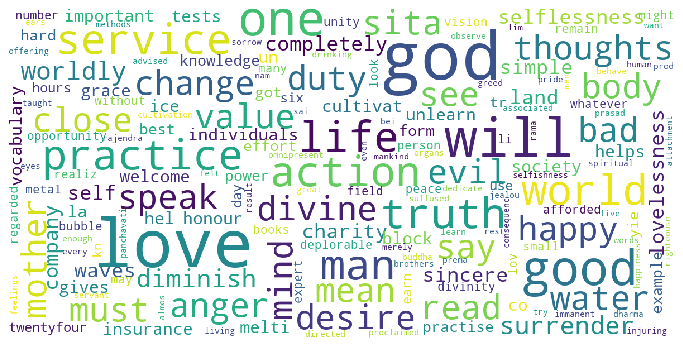

Word Cloud based on Discourse - Other Topics


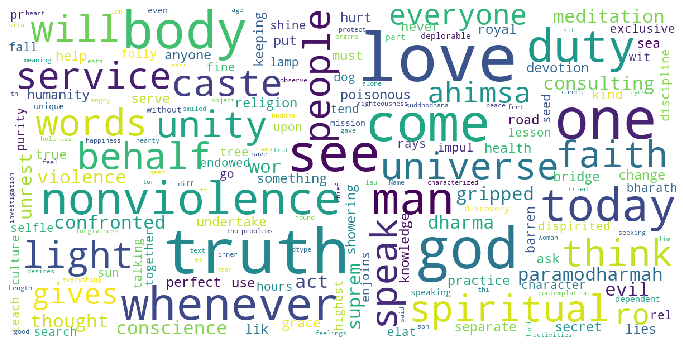

In [85]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

print("Word Cloud based on Discourse - Love")
show_wordcloud(discourseLove['text'])
print("Word Cloud based on Discourse - Right Conduct")
show_wordcloud(discourseRC['text'])
print("Word Cloud based on Discourse - Other Topics")
show_wordcloud(discourseOthr['text'])


In [70]:

print(discourseLove.describe().head())
print(discourseRC.describe().head())
print(discourseOthr.describe().head())




                                                     text
count                                                 266
unique                                                260
top     it is said jantunām narajanma durlabham birth ...
freq                                                    2
                                                     text
count                                                 244
unique                                                232
top     you should be careful not only with regard to ...
freq                                                    2
                                                     text
count                                                 163
unique                                                158
top     ahimsa paramodharmah nonviolence is the suprem...
freq                                                    2


In [87]:
## Stemmer
from nltk.corpus import stopwords
data_set1 = []

for index,row in discoursesingle.iterrows():
    data_set1.append((row['text'], row['label'],row['humanvalue']))

#change to lower case, Tokenize and removes stopwords
def preprocess(document, stem):
    
    # change sentence to lower case
    document = document.lower()
    
    # tokenize into words
    words = word_tokenize(document)
    
    # remove stop words and words less than 3 characters
    words = [word for word in words if word not in stopwords.words("english")]
    
    # replace sanskrit words represented in English to English words
    #replace Prema to Love ; Dharma to righteousness ; sathya to truth ; Shanthi / Santhi / Shanti to peace; Ahimsa to Nonviolence  
    words = [word.replace("prema","love") for word in words]
    words = [word.replace("dharma","righteousness") for word in words]
    words = [word.replace("dharmo","righteousness") for word in words]
    words = [word.replace("sathya","truth") for word in words]
    words = [word.replace("shanthi","peace") for word in words]
    words = [word.replace("santhi","peace") for word in words]
    words = [word.replace("shanti","peace") for word in words]
    words = [word.replace("ahimsa","nonviolence") for word in words]
    
    # join words to make sentence
    
    if stem:
        words = [stemmer.stem(word) for word in words]
    else:
        words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    
    document = " ".join(words)

    return document

## - Performing the preprocessing steps on all messages with length >= 3
wordtokenizedStem = []
for (text, label,humanvalue) in data_set:
    words_filtered = [e.lower() for e in preprocess(text,stem=True).split() if len(e) >= 3]
    wordtokenizedStem.append((words_filtered, label,humanvalue))   

print(wordtokenizedStem[:5])


[(['use', 'poison', 'word', 'anyon', 'word', 'wound', 'fatal', 'even', 'arrow'], 0, 'Other'), (['end', 'educ', 'charact'], 2, 'Love'), (['worldli', 'thought', 'diminish', 'thought', 'god', 'increas', 'normal', 'mind', 'time', 'desir', 'worldli', 'thing', 'desir', 'cut', 'one', 'one', 'peac', 'becom', 'stronger'], 1, 'Right_Conduct'), (['one', 'cast', 'cast', 'human', 'one', 'religion', 'religion', 'love', 'one', 'languag', 'languag', 'heart'], 0, 'Other'), (['man', 'love', 'barren', 'cloud', 'moistur', 'tree', 'fruit', 'cow', 'yield', 'milk', 'ever', 'far', 'god', 'never', 'earn', 'grace'], 0, 'Other')]


In [90]:
print(wordtokenized)

[(['use', 'poisonous', 'word', 'anyone', 'word', 'wind', 'fatally', 'even', 'arrows'], 0, 'Other'), (['end', 'education', 'character'], 2, 'Love'), (['worldly', 'thoughts', 'diminish', 'thoughts', 'god', 'increase', 'normally', 'mind', 'time', 'desire', 'worldly', 'things', 'desire', 'cut', 'one', 'one', 'peace', 'become', 'stronger'], 1, 'Right_Conduct'), (['one', 'caste', 'caste', 'humanity', 'one', 'religion', 'religion', 'love', 'one', 'language', 'language', 'heart'], 0, 'Other'), (['man', 'love', 'barren', 'cloud', 'moisture', 'tree', 'fruit', 'cow', 'yield', 'milk', 'ever', 'far', 'god', 'never', 'earn', 'grace'], 0, 'Other'), (['anger', 'ego', 'jealousy', 'biggest', 'diseases', 'keep', 'aloof', 'three', 'diseases'], 2, 'Love'), (['life', 'mosaic', 'pleasure', 'pain', 'grief', 'interval', 'two', 'moments', 'joy'], 2, 'Love'), (['surrender', 'mind', 'god', 'completely', 'take', 'care', 'every', 'way'], 1, 'Right_Conduct'), (['love', 'bridge', 'sea', 'change', 'build', 'house'], 0

## Preparing to create features

In [128]:
wordtokenizedStemDf = pd.DataFrame(list(wordtokenizedStem))

In [129]:
## - creating a single list of all words in the entire dataset for feature list creation

print(wordtokenizedStemDf)

                                                     0    1              2
0    [use, poison, word, anyon, word, wound, fatal,...  0.0          Other
1                                 [end, educ, charact]  2.0           Love
2    [worldli, thought, diminish, thought, god, inc...  1.0  Right_Conduct
3    [one, cast, cast, human, one, religion, religi...  0.0          Other
4    [man, love, barren, cloud, moistur, tree, frui...  0.0          Other
5    [anger, ego, jealousi, biggest, diseas, keep, ...  2.0           Love
6    [life, mosaic, pleasur, pain, grief, interv, t...  2.0           Love
7    [surrend, mind, god, complet, take, care, ever...  1.0  Right_Conduct
8               [love, bridg, sea, chang, build, hous]  0.0          Other
9    [chariti, mean, land, full, beggar, provid, su...  1.0  Right_Conduct
10                    [learn, speak, feel, act, speak]  2.0           Love
11                    [love, selfless, self, loveless]  1.0  Right_Conduct
12                       

In [ ]:
#Create data sets for 
# Bag of words (Stem ; lemma)
# TF-IDF (stem ; lemma)
# Word2Vec (Lemma)